In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import math
import matplotlib.pyplot as plt
from matplotlib import cm


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

import pickle
pd.set_option('display.max_columns', None)

In [2]:
##Ingest the two data sets and merge, drop redundant columns, all rows match only need to join columns
##The sensors from the second data set seem to have a different precision, we will rescale later on to fix
##this after we combine the data sets.
df10=pd.read_csv("hfm_10cols.csv")
df14=pd.read_csv("hfm_14cols.csv")
df14 = df14.drop(["hfm_runs","no_of_days"], axis=1)
##Combine dataframes 
df = pd.DataFrame()
df=pd.concat([df10, df14], axis=1, ignore_index=False)
#df = pd.merge(df10,df14,on=['hfm_runs','no_of_days'])


In [3]:
df.shape

(20631, 22)

In [4]:
df.describe()

,hfm_runs,no_of_days,sensor_2,sensor_3,sensor_10,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_1,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_15,sensor_18,sensor_19,sensor_20
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,2.063100e+04,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,1590.523119,1408.933782,47.541168,2388.096152,8143.752722,8.442146,393.210654,2388.0,642.680934,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,521.413470,3.000000e-02,100.0,38.816271,23.289705
std,29.227633,68.880990,6.131150,9.000605,0.267087,0.071919,19.076176,0.037505,1.548763,0.0,0.500053,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.737553,1.556432e-14,0.0,0.180746,0.108251
min,1.000000,1.000000,1571.040000,1382.250000,46.850000,2387.880000,8099.940000,8.324900,388.000000,2388.0,641.210000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,518.690000,3.000000e-02,100.0,38.140000,22.894200
25%,26.000000,52.000000,1586.260000,1402.360000,47.350000,2388.040000,8133.245000,8.414900,392.000000,2388.0,642.325000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,520.960000,3.000000e-02,100.0,38.700000,23.221800
50%,52.000000,104.000000,1590.100000,1408.040000,47.510000,2388.090000,8140.540000,8.438900,393.000000,2388.0,642.640000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,521.480000,3.000000e-02,100.0,38.830000,23.297900
75%,77.000000,156.000000,1594.380000,1414.555000,47.700000,2388.140000,8148.310000,8.465600,394.000000,2388.0,643.000000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,521.950000,3.000000e-02,100.0,38.950000,23.366800
max,100.000000,362.000000,1616.910000,1441.490000,48.530000,2388.560000,8293.720000,8.584800,400.000000,2388.0,644.530000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,523.380000,3.000000e-02,100.0,39.430000,23.618400


In [5]:
##Will delete sensors with zero variance(information) , that is sensors 4,9,15,17,18
df=df.drop(["sensor_4", "sensor_9","sensor_15","sensor_17","sensor_18"], axis=1)

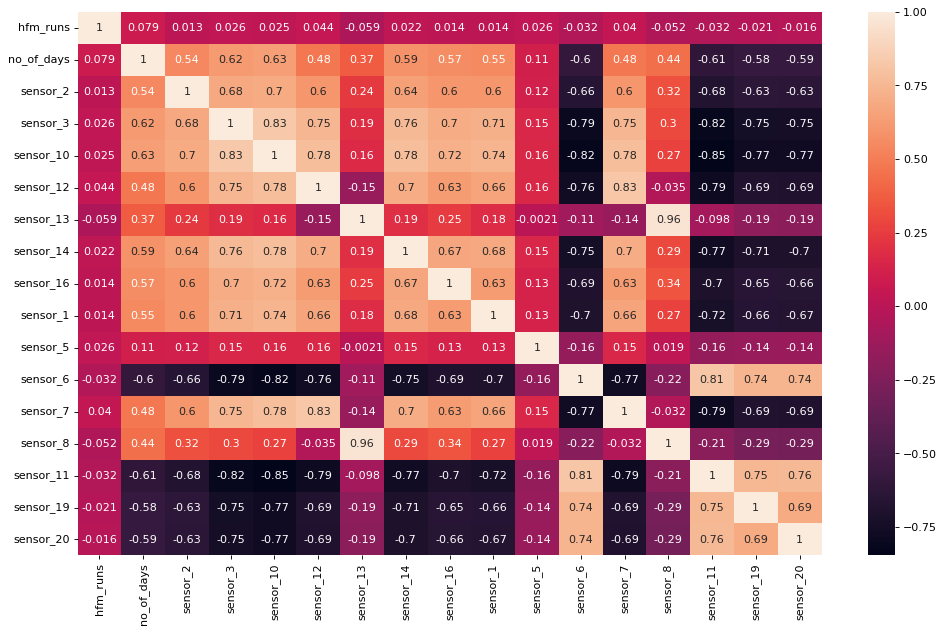

In [6]:
#There are some significane positive and negative correlation between the sensors, would need to 
#investogate further the type of data being sensed, there could be a logial explaination. 
from matplotlib.pyplot import figure
figure(figsize=(15, 9), dpi=80)

corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

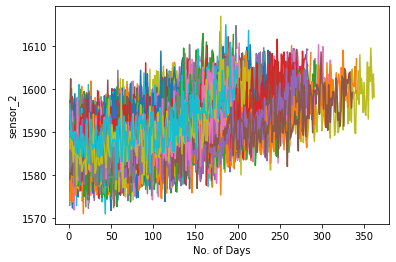

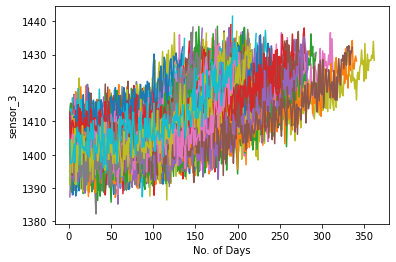

In [7]:
# Reviewing samples of sensor over the 100 machines(runs)
# Flat-line sensors were already taken out by thier variance = 0.

# The sensors below exhibit a trend upward before the machine fails. Further analysis of generating slope measures of the 
# trend could be used to make or confirm predictions of the RUL
# These sensors increase until failure indicating they could be measures of heat or vibrations or
# any other amount that in excess over time leads to failure of a machine
for sensor in df.columns[2:4]:
    for i in range(1,101):
        plt.plot(df[(df.hfm_runs==i)]['no_of_days'],df[(df.hfm_runs==i)][sensor])
        plt.xlabel('No. of Days')
        plt.ylabel(sensor)
    plt.show()

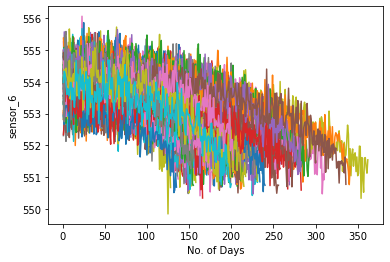

In [8]:
# The following sensor show machine failure when the values are decreasing
# This could incidate a lack of fuel or some other value whose values decreasing predicts machine failure

for sensor in df.columns[11:12]:
    for i in range(1,101):
        plt.plot(df[(df.hfm_runs==i)]['no_of_days'],df[(df.hfm_runs==i)][sensor])
        plt.xlabel('No. of Days')
        plt.ylabel(sensor)
    plt.show()

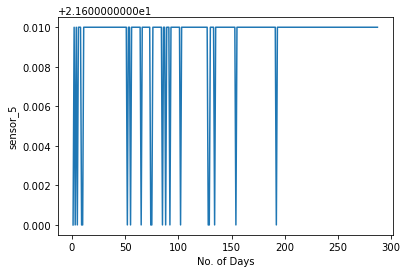

In [9]:
# This sensor jumps between extremes, so no trends are possible, but the precision indicates 
# a very sensitive measurement is occuring
# Another explaination is that the sensor itself is faulty since a few of the runs show a 
# flatline(not shown in the picture), so I will drop this sensor until further explaination is possible
for sensor in df.columns[10:11]:
    for i in range(2,3):
        plt.plot(df[(df.hfm_runs==i)]['no_of_days'],df[(df.hfm_runs==i)][sensor])
        plt.xlabel('No. of Days')
        plt.ylabel(sensor)
    plt.show()

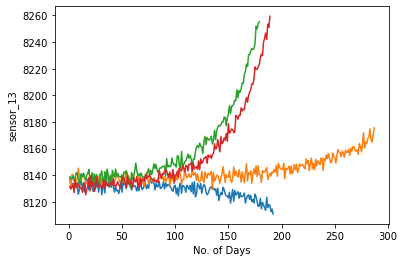

In [10]:
# A sample of 4 runs from this single sensor show failure at all levels. This could confuse the training
# when trying to detect trend so it will also be dropped, but this sensor could detect with the band if 
#it is acting properly to detect failures

for sensor in df.columns[6:7]:
    for i in range(1,5):
        plt.plot(df[(df.hfm_runs==i)]['no_of_days'],df[(df.hfm_runs==i)][sensor])
        plt.xlabel('No. of Days')
        plt.ylabel(sensor)
    plt.show()

In [11]:
# Dropping sensors 5 and 13
df=df.drop(["sensor_5", "sensor_13"], axis=1)

In [12]:
df.shape

(20631, 15)

In [13]:
#Create uniform naming of columns
columns = ["Section-{}".format(i)  for i in range(15)]
df.columns = columns
df.head()

## hfm_runs is the identification of machines runs(100 runs of the same machine). 
## no_of_days is the same as RUL that is mapped to each "machine" or in this case 100 runs of one machine
## We will have 100 maximum RUL values for each of the 100 runs

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,Section-10,Section-11,Section-12,Section-13,Section-14
0,1,1,1589.70,1400.60,47.47,2388.02,8.4195,392,641.82,554.36,2388.06,9046.19,521.66,39.06,23.4190
1,1,2,1591.82,1403.14,47.49,2388.07,8.4318,392,642.15,553.75,2388.04,9044.07,522.28,39.00,23.4236
2,1,3,1587.99,1404.20,47.27,2388.03,8.4178,390,642.35,554.26,2388.08,9052.94,522.42,38.95,23.3442
3,1,4,1582.79,1401.87,47.13,2388.08,8.3682,392,642.35,554.45,2388.11,9049.48,522.86,38.88,23.3739
4,1,5,1582.85,1406.22,47.28,2388.04,8.4294,393,642.37,554.00,2388.06,9055.15,522.19,38.90,23.4044


In [14]:
#Keep variable groups organized
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
Sensor_name = ["Section-{}".format(i) for i in range(2,15)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [15]:
## max_cycles are the failure times for each of the 100 machines 
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [16]:
#Drop the identifier, not needed for modeling
df.drop(columns=['Section-0'])

,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,Section-10,Section-11,Section-12,Section-13,Section-14
0,1,1589.70,1400.60,47.47,2388.02,8.4195,392,641.82,554.36,2388.06,9046.19,521.66,39.06,23.4190
1,2,1591.82,1403.14,47.49,2388.07,8.4318,392,642.15,553.75,2388.04,9044.07,522.28,39.00,23.4236
2,3,1587.99,1404.20,47.27,2388.03,8.4178,390,642.35,554.26,2388.08,9052.94,522.42,38.95,23.3442
3,4,1582.79,1401.87,47.13,2388.08,8.3682,392,642.35,554.45,2388.11,9049.48,522.86,38.88,23.3739
4,5,1582.85,1406.22,47.28,2388.04,8.4294,393,642.37,554.00,2388.06,9055.15,522.19,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,1597.98,1428.63,48.07,2388.26,8.4956,397,643.49,551.43,2388.19,9065.52,519.49,38.49,22.9735
20627,197,1604.50,1433.58,48.04,2388.22,8.5139,395,643.54,550.86,2388.23,9065.11,519.68,38.30,23.1594
20628,198,1602.46,1428.18,48.09,2388.24,8.5646,398,643.42,550.94,2388.24,9065.90,520.01,38.44,22.9333
20629,199,1605.26,1426.53,48.39,2388.23,8.5389,395,643.23,550.68,2388.25,9073.72,519.67,38.29,23.0640


In [17]:
#Rescalling data since we had differences in precision between the two raw data sets that were prvisouly joined
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
pt = PowerTransformer()
df = pt.fit_transform(df)

In [18]:
##Remove any Nan values
df=np.nan_to_num(df)

In [19]:
## For each of the Machine Ids(1,...,100), we reverse the list of RUL values
## This function creates the RULs values that we regress upon for making more predictions of future RUL values
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [20]:
## Try two standard models, see which one is best
## Only using training data to fit the models
X = np.array(df)
y = np.array(RUL_df()).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)


LinearRegression()

In [21]:
#Determine common error of (true_y-pred_y) for each of the models
#It looks like Random Forest is giving the best results
pred_f = forest_model.predict(X)
pred_lin = lin_model.predict(X)


print("RF mean_squared_error >> ", mean_squared_error(y, pred_f))
print("RF mean_absolute_error >>",mean_absolute_error(y, pred_f))

print("LR mean_squared_error >> ", mean_squared_error(y, pred_lin))
print("LR mean_absolute_error >>",mean_absolute_error(y, pred_lin))


RF mean_squared_error >>  81.87974837380641
RF mean_absolute_error >> 5.568389801754642
LR mean_squared_error >>  1455.4751156923842
LR mean_absolute_error >> 28.85733751745604


In [22]:
## Validate with the test data
## The Random Forest is provising the best estimate with test data
print("Acc of Linear Regression >> ",lin_model.score(X_test, y_test))
print("Acc of Random Forest >> ",forest_model.score(X_test, y_test))

Acc of Linear Regression >>  0.6920716940560612
Acc of Random Forest >>  0.9466999421920593


In [23]:
forest_pred = forest_model.predict(X_test)
print("mean_squared_error >> ", mean_squared_error(y_test, forest_pred))
print("mean_absolute_error >>",mean_absolute_error(y_test, forest_pred))

mean_squared_error >>  256.9380877877393
mean_absolute_error >> 11.07289798885389


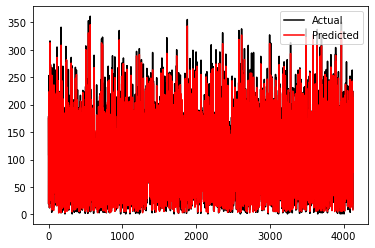

In [24]:
plt.plot(y_test,c='k',label='Actual')
plt.plot(forest_pred,c='red',label='Predicted')
plt.legend()
plt.show()

In [25]:
#Next steps would be to test, but no test data given. Time Series is usually Train/Validate/Test 
#with test data being the most recent

In [26]:
#Lets Pickle the data
pickle.dump(forest_model, open('forest_model.sav', 'wb'))

In [ ]:
#Add the flask API call HERE!!!!!

In [ ]:
#Summary: 
#After a brief EDA, several sensors were dropped because they were either flatline
#or needed further investigation to see if they could detect failures at both
#minumum or maxumum levels. Several sensors were also correlated, and further investigation
#as to the configuration of sensors is needed...did they have redundancy(many sensors measuring the same values) should
#be inquired to determined if that is where the correlations are originating. 

#Remaining Useful Life measures were created from the column that showed how long
#a sensor was used until a failure occured. Those RUL values were used for the sensors to
#regress upon for modeling purposes. Two models were initially choosen with Random Forest being the clear winner.

#The model was pickled to be used with an API inference engine to make further predictions once data is updated.	#